## Sentiment Analysis of Amazon reviews for BD Coffee make

In this notebook, the reviews from Amazon on Black and Decker Coffee Maker analyzed. 

In [262]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlite3
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

#### Data Preparation and Visualization:

In [263]:
#reading the sqlite file and making a df from the data
con = sqlite3.connect("Amazon.sqlite")
df = pd.read_sql_query("SELECT * from JLB", con)

In [264]:
#Showing the head of the dataset
df.head()

,rating,date,location,color,review_title,review,comment
0,1.0,January-29-2019,United States,Gray,Buy a Charge 3,The JBL Charge 4 has one giant flaw that frank...,11
1,3.0,December-12-2018,United States,Black,JBL could make the Charger4 better BUT nop the...,Too bad JBL lower the sound quality on the cha...,3
2,5.0,October-26-2018,United States,Black,Sounds great and has plenty of colume,I've been using a JBL Flip 2 for the past coup...,1
3,5.0,June-3-2019,United States,Gray,In depth review for jbl charge 4,The JBL charge 4 is a great product. I found i...,2
4,4.0,December-5-2018,United States,Red,Awesome Sound! We'll see how long it lasts!,Great build quality.Great sound!Does not autom...,1


In [265]:
df.shape

(1652, 7)

Checking to see if there is any null data in our dataset:

In [266]:
df_nulls = df[df.isnull().apply(lambda x: max(x), axis=1)]
df_nulls.head()

,rating,date,location,color,review_title,review,comment
1651,5.0,June-4-2019,United States,None,None,None,None


In [267]:
df.reset_index()
df.dropna()
df.drop_duplicates()
df = df.mask(df.eq('None')).dropna()

In [268]:
df_nulls = df[df.isnull().apply(lambda x: max(x), axis=1)]
df_nulls.head()

,rating,date,location,color,review_title,review,comment


Changing the rating values to a binary form. To do this, first we check the relationship between rating and comments:

In [269]:
#converting the data to numerical
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df = df.replace(np.nan, 0, regex=True)
df['comment'] = pd.to_numeric(df['comment'], errors='coerce')
df = df.replace(np.nan, 0, regex=True)

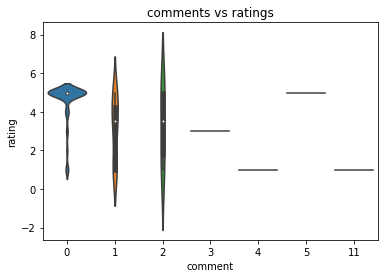

In [271]:
sns.violinplot(df['comment'], df['rating'])
plt.title("comments vs ratings")
plt.show()

We assign ratings above 3 as 1 and below 3 as 0.

In [272]:
df['rating'] = np.where(df['rating'] >= 3, 1, 0)

In [273]:
df.sample(10)

,rating,date,location,color,review_title,review,comment
808,1,January-26-2020,United States,Black,Highly recommend,Deep bass for a small speaker. Also has great ...,0
1640,1,August-15-2019,United States,Black,DURABLITY,Hands down a stud. Best Bluetooth speaker on t...,0
1280,1,November-5-2019,United States,Camouflage,Works great,Bought for a small job site speaker and it wor...,0
1057,1,January-22-2020,United States,Camouflage,missing 1 item from inside,i got the jbl speaker in the box with the char...,0
138,1,April-2-2019,United States,Gray,"Great battery, a little bass heavy for indoors.",This device sounds great. It's a little bass h...,0
1258,1,April-7-2019,United States,Black,Jbl,Funciona tal al precio,0
926,1,July-26-2019,United States,Black,Awesome,The speaker is amazing! The sound from this li...,0
303,1,August-15-2019,United States,Blue,Great bass and clear audio,This speaker sounds great and has an awesome b...,0
463,1,July-26-2019,United States,Sand,Damn,"When I recurved it I was so amazed, let alone ...",0
879,1,January-20-2020,United States,Teal,Great gift,Grandson loved it,0


Performing some statistical analysis on the data

In [274]:
df.describe()

,rating,comment
count,1651.000000,1651.000000
mean,0.918231,0.039976
std,0.274095,0.464080
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,0.000000
max,1.000000,11.000000


In [275]:
df.groupby('rating').describe()

comment                                              
         count      mean       std  min  25%  50%  75%   max
rating                                                      
0        135.0  0.259259  1.398096  0.0  0.0  0.0  0.0  11.0
1       1516.0  0.020449  0.238762  0.0  0.0  0.0  0.0   5.0

According to the table above most of the users are satisfied with the JLB Speaker.

Here we will add a new column to our dataframe and will check the length of the reviews:

In [276]:
#Adding a new column and entering the length of the reviews:
df['length_of_review'] = df['review'].apply(len)
df.head()

,rating,date,location,color,review_title,review,comment,length_of_review
0,0,January-29-2019,United States,Gray,Buy a Charge 3,The JBL Charge 4 has one giant flaw that frank...,11,345
1,1,December-12-2018,United States,Black,JBL could make the Charger4 better BUT nop the...,Too bad JBL lower the sound quality on the cha...,3,238
2,1,October-26-2018,United States,Black,Sounds great and has plenty of colume,I've been using a JBL Flip 2 for the past coup...,1,531
3,1,June-3-2019,United States,Gray,In depth review for jbl charge 4,The JBL charge 4 is a great product. I found i...,2,2636
4,1,December-5-2018,United States,Red,Awesome Sound! We'll see how long it lasts!,Great build quality.Great sound!Does not autom...,1,614


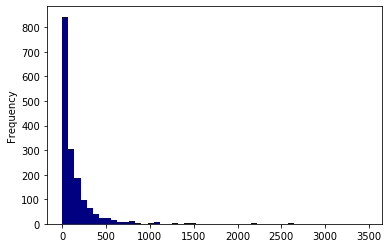

In [277]:
#Plotting the histogram of the length of reviews
df['length_of_review'].plot(bins=50, kind='hist', color='navy');

The Distribution Plot above, illustrates a distribution of Length of the Reviews written by buyers for BD Coffee Maker. Most of the Reviews are between 0 to 500 words.

In [278]:
#Describing the data according to the length of reviews
df.groupby('length_of_review').describe().sample(10)

rating                                                 \
                  count      mean       std  min   25%  50%   75%  max   
length_of_review                                                         
157                 2.0  0.500000  0.707107  0.0  0.25  0.5  0.75  1.0   
159                 5.0  0.800000  0.447214  0.0  1.00  1.0  1.00  1.0   
284                 1.0  1.000000       NaN  1.0  1.00  1.0  1.00  1.0   
130                 3.0  0.666667  0.577350  0.0  0.50  1.0  1.00  1.0   
54                 12.0  1.000000  0.000000  1.0  1.00  1.0  1.00  1.0   
37                 11.0  0.909091  0.301511  0.0  1.00  1.0  1.00  1.0   
1406                2.0  1.000000  0.000000  1.0  1.00  1.0  1.00  1.0   
407                 1.0  1.000000       NaN  1.0  1.00  1.0  1.00  1.0   
551                 1.0  0.000000       NaN  0.0  0.00  0.0  0.00  0.0   
92                  8.0  0.750000  0.462910  0.0  0.75  1.0  1.00  1.0   

                 comment                                     
                   count mean  std  min  25%  50%  75%  max  
length_of_review                                             
157                  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
159                  5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
284                  1.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0  
130                  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
54                  12.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
37                  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1406                 2.0  5.0  0.0  5.0  5.0  5.0  5.0  5.0  
407                  1.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0  
551                  1.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0  
92                   8.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

Here we will plot the histograms of the length of reviews for high ratings and low ratings to see if there is a difference:

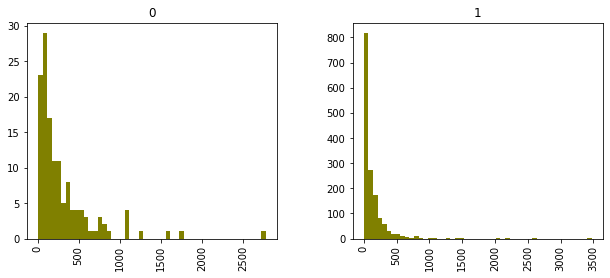

In [279]:
df.hist(column='length_of_review', by='rating', bins=50,figsize=(10,4), color='olive');

Unsatisfied people have written longer sentences when reviewing the product.

Here in a Pie Chart the percentage of satisfied versus unsatisfid people with the Coffee Maker will be depicted.

In [280]:
import plotly.graph_objs as go
import plotly.offline as py

In [281]:
ratings = df['rating'].value_counts()
colors = ['gold', 'mediumturquoise']

label_rating = ratings.index
size_rating = ratings.values

rating_piechart = go.Pie(labels = label_rating,
                         values = size_rating,
                         name = 'JBL Speaker', hole = 0.0)

pdf = [rating_piechart]

layout = go.Layout(title = 'Distribution of Ratings for JBL Speaker')

fig = go.Figure(data = pdf, layout = layout)
fig.update_traces(hoverinfo='label+percent+value', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

py.iplot(fig)

Adding another column to the dataframe named feedback and specifying in it which review has received a comment (1) and which has not(0).

In [282]:
df['feedback'] = np.where(df['comment'] > 0, 1, 0)

In [283]:
df.sample(10)

,rating,date,location,color,review_title,review,comment,length_of_review,feedback
1037,1,October-27-2019,United States,Black,Good sound system!,Good quality sound system!!,0,27,0
476,1,September-20-2019,United States,Red,Excelente,"Me gustó todo es elegante, buen sonido, i muy ...",0,75,0
311,1,January-30-2020,United States,Camouflage,Love this speaker,More than we were expecting. Absolutely love t...,0,183,0
1193,1,July-6-2019,United States,Red,Conectivity and sound are superb,Sounds excelente,0,16,0
428,0,June-18-2019,United States,Black,Skip,The sound is not that great. It sounds like my...,0,58,0
1636,0,December-30-2019,United States,Red,"Smaller than I expected, but pretty big sound",An adequate portable wireless speaker for a sm...,0,74,0
174,1,January-2-2020,United States,Camouflage,Great Sound!,"This was a gift for my son, and upon receiving...",0,247,0
968,0,August-19-2019,United States,Red,sonido muy bajito,el sonido es muy bajito para ser del tamaño qu...,0,115,0
715,1,August-19-2019,United States,Blue,Well made,Great portable boom box with long battery life...,0,78,0
1465,1,May-26-2019,United States,Red,Great product,Great product,0,13,0


In [284]:
df.describe()

,rating,comment,length_of_review,feedback
count,1651.000000,1651.000000,1651.000000,1651.000000
mean,0.918231,0.039976,144.966081,0.016354
std,0.274095,0.464080,248.560484,0.126870
min,0.000000,0.000000,1.000000,0.000000
25%,1.000000,0.000000,25.500000,0.000000
50%,1.000000,0.000000,67.000000,0.000000
75%,1.000000,0.000000,168.000000,0.000000
max,1.000000,11.000000,3473.000000,1.000000


Here the most frequenctly repeated words in reviews will be retreived.

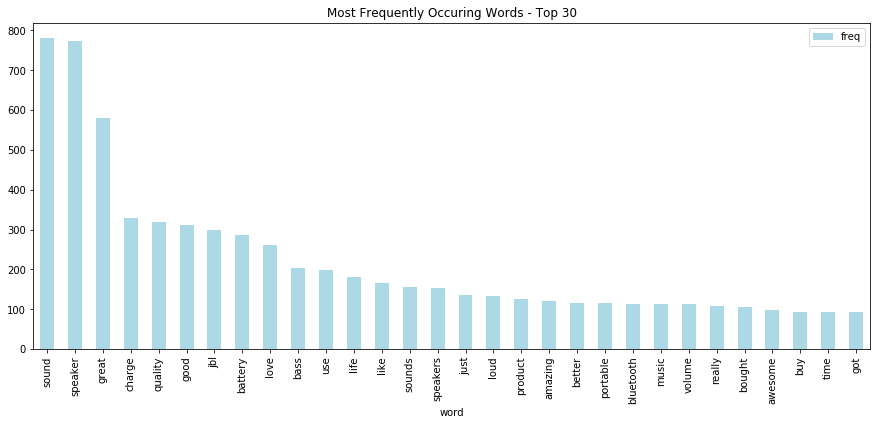

In [285]:
from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df.review) #learn a vocabulary
sum_words = words.sum(axis=0)


words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', color='lightblue', figsize=(15, 6))
plt.title("Most Frequently Occuring Words - Top 30")
plt.show()

The bar graph above indicates the most frequently used words in the reviews. This will give us some idea about people's thoughts on the JBL Speaker.

In [286]:
import spacy
import string
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

!python -m spacy download en_core_web_md

stopwords = stopwords.words('english')
punctuations = string.punctuation
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kaveh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [287]:
import spacy
import string
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

!python -m spacy download en_core_web_md


stopwords = stopwords.words('english')
punctuations = string.punctuation
nlp = spacy.load('en_core_web_sm')
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    table = str.maketrans({key: None for key in string.punctuation})

    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        ###Convert text to lowercase, strip whitespace and remove personal pronouns
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        ###Remove stopwords
        tokens = [tok.translate(table) for tok in tokens if tok not in stopwords ]
        tokens = ' '.join(tokens)
        #Remove extra whitespace
        tokens = ' '.join(tokens.split())
        texts.append(tokens)
    return pd.Series(texts)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kaveh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


Defining two variables (X, y) which are our train and test variables. X that is a train variable, would be a text from 'review_title' and test variable (y) would be the 'feedback'.

In [303]:
X = cleanup_text(df["review"],logging=True)
y = df.iloc[:,0].values

Processed 1000 out of 1651 documents.


#### Bag of Words 
The following script uses the bag of words model to convert text documents into corresponding numerical features:


In [290]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
X_train = vectorizer.fit_transform(X).toarray()

In [291]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
X_train = tfidfconverter.fit_transform(X_train).toarray()

The above script convert values into TFIDF values.

This script divides data into 20% test set and 80% training set.

In [298]:
#training and testing
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_train, y, test_size = 0.2, random_state = 0)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1320, 677)
(1320,)
(331, 677)
(331,)


In [299]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

classifier = RandomForestClassifier()
classifier.fit(x_train, y_train)

y_pred = classifier.predict(x_test)

print("Training Accuracy :", classifier.score(x_train, y_train))
print("Testing Accuracy :", classifier.score(x_test, y_test))

cm = confusion_matrix(y_test, y_pred)
print(cm)

Training Accuracy : 0.9946969696969697
Testing Accuracy : 0.9274924471299094
[[  4  19]
 [  5 303]]


In [300]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print( '------------------------------', 'Confusion Matrix:', '\n', confusion_matrix(y_test,y_pred))
print('\n', '------------------------------', 'F1 measure:', '\n', '\n', classification_report(y_test,y_pred))
print('\n',  '------------------------------', 'Accuracy Score:', '\n', accuracy_score(y_test, y_pred))

------------------------------ Confusion Matrix: 
 [[  4  19]
 [  5 303]]

 ------------------------------ F1 measure: 
 
              precision    recall  f1-score   support

          0       0.44      0.17      0.25        23
          1       0.94      0.98      0.96       308

avg / total       0.91      0.93      0.91       331


 ------------------------------ Accuracy Score: 
 0.9274924471299094
